# Using netMHC predictions

In [1]:
import glob
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from lib import *
from IPython.display import display, HTML
import weblogolib
from corebio.seq import SeqList, Alphabet

In [2]:
dfbinders = pd.concat(pd.read_csv(filename, sep=',') for filename in glob.glob('/home/amayer/data/peptidome/netmhc/Malaria-HLA-*.csv'))

In [3]:
'FMKAVCVEV' in pd.read_csv('/home/amayer/data/peptidome/netmhc/Malaria-HLA-A0201.csv', sep=',')['Peptide']

False

In [4]:
len(dfbinders['Peptide'].unique()), len(np.array(dfbinders['Peptide']))

(245328, 487695)

In [5]:
# 50nM = strong binding
# 500nM = weak binding
dfbinders = dfbinders[dfbinders['nM']<500]
dfbinders.head()

,Unnamed: 0,Pos,Peptide,ID,nM,Rank,Core,H_Avg_Ranks,N_binders
0,4,4,FVFILSVLI,sp_C6KT68_FENR_,260.5,3.00,FVFILSVLI,3.00,0
1,7,7,ILSVLISGV,sp_C6KT68_FENR_,4.3,0.06,ILSVLISGV,0.06,1
2,10,10,VLISGVCCI,sp_C6KT68_FENR_,38.2,1.00,VLISGVCCI,1.00,1
3,29,29,RMTAHSRFL,sp_C6KT68_FENR_,51.3,1.20,RMTAHSRFL,1.20,1
4,62,62,NLYTVKNPL,sp_C6KT68_FENR_,52.9,1.20,NLYTVKNPL,1.20,1


In [6]:
seqs = SeqList(list(dfbinders['Peptide']), alphabet=Alphabet(aminoacids))
data = weblogolib.LogoData.from_seqs(seqs)
options = weblogolib.LogoOptions()
options.logo_title = 'HLA-A0101'
f = weblogolib.LogoFormat(data, options)
svg = weblogolib.svg_formatter(data, f)
display(HTML(svg.decode('ascii')))

In [7]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df = df.set_index('seq')
humanaaprobdict = np.log10(df['freq']).to_dict()

df1 = counter_to_df(count_kmers_proteome(human, 2), norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log10(count).to_dict()

df2 = counter_to_df(count_kmers_proteome(human, 3), norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log10(count).to_dict()

Malaria
200
11207814 4130330 64 245328


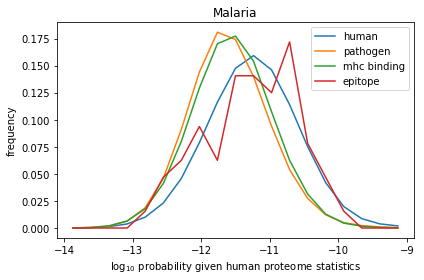

In [8]:
dfproteomes = pd.read_csv('../data/proteomes.csv', sep=',')
pathogenproteomes = dfproteomes[dfproteomes['type'].isin(['parasite'])]

#dfepitopes = pd.read_csv(datadir+'allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitopes = pd.read_csv(datadir+'iedb-Malaria-MHCI-humanhost.csv', header=1, usecols=(2, 9, 14))
dfepitopes = dfepitopes.fillna('')
dfepitopes['length'] = [len(d) for d in dfepitopes['Description']]

loglikelihood = lambda seq, k: loglikelihood_triplet(seq, humanaaprobdict, humandoubletprobdict, humantripletprobdict, k=k)
likelihoodname = 'triplet'

#for k in [9, 15]:
for k in [9]:
    phuman = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

    for idx, row in pathogenproteomes.iterrows():
        name = row['shortname']
        iedbname = row['iedbname']
        path = datadir + row['path']
        print(name)

        dfepitope = dfepitopes[dfepitopes['Parent Organism'].str.contains(iedbname)]
        print(len(dfepitope))

        epi = list(dfepitope[dfepitope['length']==k]['Description'])
        pepitope = np.array([loglikelihood(seq, k) for seq in epi])
        #epi = list(dfepitope['Description'])
        #pepitope = np.array([loglikelihood(seq[i:i+k], k) for seq in epi for i in range(len(seq)-k+1)])
        pepitope = pepitope[~np.isnan(pepitope)]
        
        ppredepitope = np.array([loglikelihood(seq, k) for seq in dfbinders['Peptide'].unique()])
        ppredepitope = ppredepitope[~np.isnan(ppredepitope)]

        ppathogen = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(path) for i in range(len(seq)-k+1) ])
        ppathogen = ppathogen[~np.isnan(ppathogen)]

        print(len(phuman), len(ppathogen), len(pepitope), len(ppredepitope))

        if len(pepitope) > 2:
            fig, ax = plt.subplots()
            plot_histograms([phuman, ppathogen, ppredepitope, pepitope],
                            ['human', 'pathogen', 'mhc binding', 'epitope'],
                            nbins=20,
                            xmin=-14, xmax=-9, ax=ax)
            ax.set_ylabel('frequency')
            ax.set_xlabel('$\log_{10}$ probability given human proteome statistics')
            plt.title(name)
            fig.tight_layout()
            #fig.savefig('plots/likelihoodprofile-%s-%s-k%i.png' % (name, likelihoodname, k), dpi=300)

In [9]:
dfepi9 = dfepitope[dfepitope['length'] == 9]

In [10]:
len(set(dfepi9['Description'])), len(set(dfepi9['Description']) - set(dfbinders['Peptide'].unique()))

(64, 42)

In [11]:
with open('peptides.txt', 'w') as f:
    for item in list(dfepi9['Description']):
        f.write("%s\n" % item)

In [12]:
!netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p

# /home/amayer/software/netMHC-4.0//Linux_x86_64/bin/netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p
# Mon Oct 15 23:45:51 2018
# User: amayer
# PWD : /home/amayer/repos/peptidome/code
# Host: Linux GEN-AMAYER 4.15.0-36-generic x86_64
# -xls     1                    Save output to xls file
# -xlsfile peptides.csv         File name for xls output
# -a       HLA-A0101            HLA allele name
# -p       1                    Switch on if input is a list of peptides (Peptide format)
# Command line parameters set to:
#	[-a line]            HLA-A0101            HLA allele name
#	[-f filename]                             Input file (by default in FASTA format)
#	[-p]                 1                    Switch on if input is a list of peptides (Peptide format)
#	[-l string]          9                    Peptide length (multiple lengths separated by comma e.g. 8,9,10)
#	[-s]                 0                    Sort output on decreasing affinity
#	[-rth float]         0.500000

In [13]:
pd.read_csv('peptides.csv', sep='\t', skiprows=1)

,Pos,Peptide,ID,nM,Rank,Core,H_Avg_Ranks,N_binders
0,0,ALFFIIFNK,PEPLIST,19493.6,9.00,ALFFIIFNK,9.00,0
1,0,ALIIIRSLL,PEPLIST,18527.3,8.00,ALIIIRSLL,8.00,0
2,0,ASKNKEKAL,PEPLIST,32101.4,46.00,ASKNKEKAL,46.00,0
3,0,DLLEEGNTL,PEPLIST,25498.6,20.00,DLLEEGNTL,20.00,0
4,0,EPAPFDETL,PEPLIST,24209.9,17.00,EPAPFDETL,17.00,0
5,0,EPKDEIVEV,PEPLIST,28640.6,31.00,EPKDEIVEV,31.00,0
6,0,FMKAVCVEV,PEPLIST,17231.1,7.00,FMKAVCVEV,7.00,0
7,0,FVEALFQEY,PEPLIST,39.5,0.07,FVEALFQEY,0.07,1
8,0,GIAGGLALL,PEPLIST,22880.5,14.00,GIAGGLALL,14.00,0
9,0,GLIMVLSFL,PEPLIST,16880.7,6.50,GLIMVLSFL,6.50,0
